## **AdaBoost (SAMME & R2)**
The next powerful machine learning algorithm is AdaBoost (adaptive boosting), which is based on the concept of boosting, when weak basic models are consistently combined into one strong one correcting the mistakes of their predecessors.

In AdaBoost the stump of solutions is used as the base model (other models can be used) — a tree with a small depth, which is assigned a vector of weights of size N, each value of which corresponds to a certain value y_train and is initially equal to $\frac{1}{N}$, where N is the number of samples in the training dataset. Each subsequent stump is trained taking into account the weights calculated based on the errors of the previous prediction. Also for each trained stump, a weight is calculated separately used to assess the importance of the final predictions.

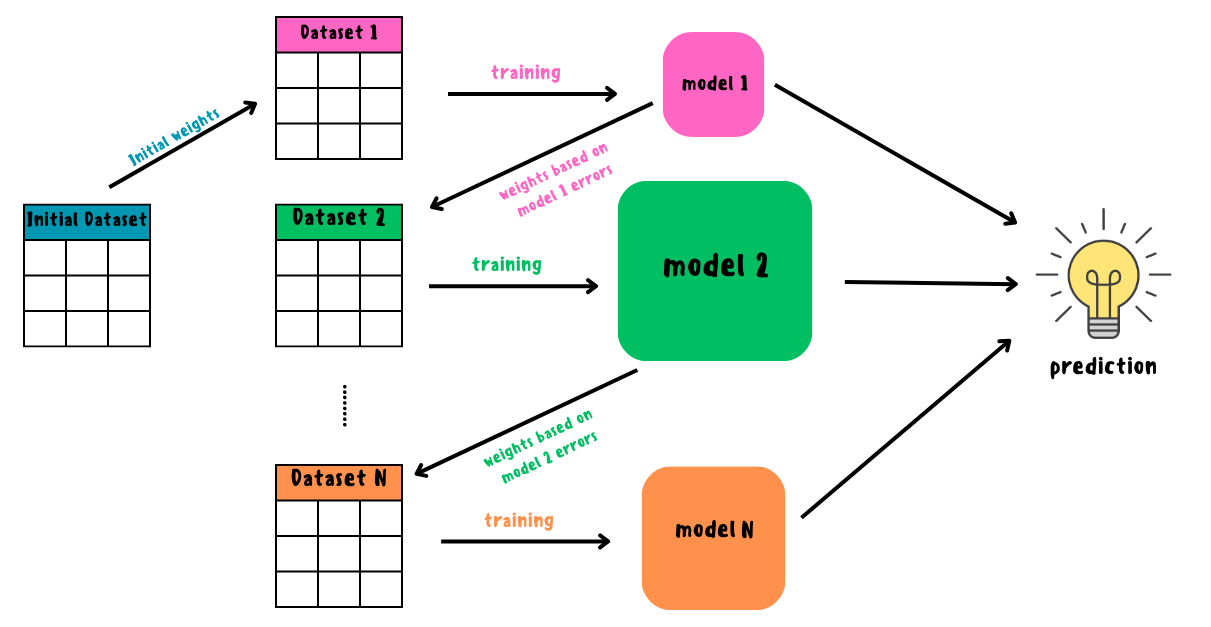

### **The principle of operation of adaptive boosting for classification**
**SAMME** (Stagewise Additive Modeling using a Multiclass Exponential loss function) is a version of AdaBoost for multiclass classification. If the basic models estimate the probabilities of classes, then this version is called *SAMME.R*, where R (Real) is real and in general has higher accuracy.

**The algorithm is constructed as follows**:
- 1) each y_train value is assigned the same weight;
- 2) a stump with a depth of 1 is trained on X_train and the proportion of incorrect predictions is calculated, based on which the weighted error rate is calculated;
- 3) based on the weighted error frequency the weight of the stump is calculated;
- 4) for incorrect predictions weights are updated (increased) and normalized, taking into account the weight of the stump;
- 5) the next stump is trained on X_train, taking into account the updated weights: a new set of samples of the same size is being built, in which incorrectly classified samples (those with more weight) will be more common;
- 6) steps 2-5 are repeated for each stump;
- 7) each trained stump makes a prediction of 1 X_test sample;
- 8) next, the weights of the stumps are summed up for each predicted class;
- 9) the class with the maximum sum of weights will be the final prediction;
- 10) this procedure is repeated for all samples in the test dataset.

**Formulas for calculations**

$r_j = \sum\limits_{i=1}^{m} w_i (\hat{y_j}^{(i)} \neq {y}^{(i)}) \ - \ $ weighted error rate of $j^{th}$ stump \\

$α_j = η \ log(\frac{1 - r_j}{r_j}) + log(K - 1) \ - \ $ stump weight \\

$set \ $ $w^{(i)} \leftarrow w^{(i)} exp(α_j) \ (\hat{y_j}^{(i)} \neq {y}^{(i)}) \ and \  normalize $ \\

$\hat{y}(x) = argmax \sum\limits_{j=1}^{N} α_j (\hat{y}_j(x) = k) \ - \ $ prediction \\

$\hat{y_j}^{(i)} \ - \ $  $j^{th} \ $ prediction for $i^{th} \ $ sample \\

$η \ - \ $ learning rate

$K \ - \ $ number of classes

### **The principle of adaptive boosting for regression**
In the case of regression *AdaBoost.R2* works in a similar way, except for some features: an absolute error is used to assess the quality of the stump predictions and the final prediction is performed using the [weighted median](https://iq.opengenus.org/weighted-median-problem/), the essence of which is to assign weights to the sorted elements of the list and select the one whose cumulative sum is more than half of the total.

**The algorithm is constructed as follows**:
- 1) each y_train value is assigned the same weight;
- 2) a stump with a depth of 3 is trained on X_train and the absolute error is calculated for each predicted sample;
- 3) after that, the adjusted errors for the instances and the stump are calculated, as well as the coefficient $β$ based on them;
- 4) based on the coefficient $β$, the weight of the stump is found;
- 5) next, weights are updated and normalized for all samples, taking into account the weight of the stump;
- 6) the next stump is trained on X_train, taking into account the updated weights: a new set of samples of the same size is being built, in which samples with large weights will be more common;
- 7) steps 2-6 are repeated for each stump;
- 8) all X_test samples are predicted on each trained stump;
- 9) the median prediction index is searched for each sample;
- 10) The predictions from step 8 are based on the median prediction indices for each sample will be the final predictions.

**Formulas for calculations**

$e_{abs} = |\hat{y_j}^{(i)} - {y}^{(i)}| \ - \ $ absolute instance error

$e_{l} = \frac{e_{abs}}{max(e_{abs})} \ - \ $ adjusted instance errors

$\overline{e} = \sum\limits_{i=1}^{n} w^{(i)} e_l^{(i)} \ - \ $ adjusted stump error

$β = \frac{\overline{e}}{1 - \overline{e}}$

$w^{(i)} = η \ ln(\frac{1}{β})$

$update \ $ $w^{(i)} \leftarrow w^{(i)} β_i^{1 - e_{l}} \ and \ normalize$

$\hat{y}(x) = weighted \ median (\hat{y_j}^{(i)}) \ - \ $ prediction

$\hat{y_j}^{(i)} \ - \ $  $j^{th} \ $ prediction for $i^{th} \ $ sample

$η \ - \ $ learning rate

### **Python implementation from scratch**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from mlxtend.plotting import plot_decision_regions

In [23]:
class AdaBoost:
    def __init__(self, regression=False, n_estimators=50, learning_rate=1.0, random_state=0):
        self.regression = regression
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.stumps = []
        self.weights = []

    def _update_weights(self, args):
        if self.regression:
            weights, beta, loss_function = args
            weights *= beta ** (1 - loss_function)
        else:
            weights, wrong_predictions, stump_weight = args
            weights[wrong_predictions] *= np.exp(stump_weight)

        return weights

    @staticmethod
    def _normalize(weights: np.ndarray):
        return weights / sum(weights)

    def fit(self, X, y):
        n_samples = len(y)
        self.K = len(np.unique(y.values))   # num unique classes
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            if self.regression:
                stump = DecisionTreeRegressor(max_depth=3, random_state=self.random_state)
                stump_predictions = stump.fit(X, y, sample_weight=weights).predict(X)

                abs_instance_errors = abs(stump_predictions - y)
                adjusted_instance_errors = abs_instance_errors / max(abs_instance_errors)
                adjusted_stump_error = sum(weights * adjusted_instance_errors)

                if adjusted_stump_error >= 0.5:
                    self.stumps.pop(-1)
                    break

                beta = adjusted_stump_error / (1 - adjusted_stump_error)
                stump_weight = self.learning_rate * np.log(1 / beta)
                args = [weights, beta, adjusted_instance_errors]
            else:
                stump = DecisionTreeClassifier(max_depth=1, random_state=self.random_state)
                stump_predictions = stump.fit(X, y, sample_weight=weights).predict(X)

                wrong_predictions = stump_predictions != y
                r = sum(weights[wrong_predictions])   # weighted_error_rate
                stump_weight = self.learning_rate * np.log((1 - r) / r) + np.log(self.K - 1)
                args = [weights, wrong_predictions, stump_weight]

            self.stumps.append(stump)
            self.weights.append(stump_weight)
            weights= self._update_weights(args)
            weights = self._normalize(weights)

    def _max_weighted_votes(self, samples):
        n_samples = len(samples)
        sample_indexes = np.array(range(n_samples))
        prediction_weights = np.zeros((n_samples, self.K))

        for i in range(self.n_estimators):
            stump_prediction = self.stumps[i].predict(samples)
            prediction_weights[sample_indexes, stump_prediction] += self.weights[i]

        return np.argmax(prediction_weights, axis=1)

    def _weighted_median_prediction(self, samples):
        n_samples = len(samples)
        sample_indexes = np.arange(n_samples)
        predictions = np.array([stump.predict(samples) for stump in self.stumps]).T
        sorted_pred_indexes = np.argsort(predictions, axis=1)

        # Find index of median prediction for each sample
        cumsum_weights = np.array(self.weights)[sorted_pred_indexes].cumsum(axis=1)
        is_over_median = cumsum_weights >= 0.5 * sum(self.weights)   # True/False matrix
        median_indexes = is_over_median.argmax(axis=1)
        median_prediction_indexes = sorted_pred_indexes[sample_indexes, median_indexes]

        return predictions[sample_indexes, median_prediction_indexes]

    def predict(self, samples):
        if self.regression:
            return self._weighted_median_prediction(samples)
        else:
            return self._max_weighted_votes(samples)

In [24]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Glass Classification](https://www.kaggle.com/datasets/uciml/glass) dataset will be used to train models where it is necessary to correctly determine the type of glass by its characteristics. In the case of regression Diabetes dataset from scikit-learn is used.

In [25]:
df_path = "/content/drive/MyDrive/glass.csv"
glass_df = pd.read_csv(df_path)
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [26]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Model training and evaluation of the obtained results**
In the case of classification low accuracy is due to the fact that AdaBoost does not work well with unbalanced data, trying to minimize error on objects from a smaller class, which often leads to overfitting on these objects and to a decrease in the accuracy of the model in general.

In the case of regression, the error is less than in the random forest algorithm, since there is a relatively high degree of correlation between the features in the data used, which AdaBoost copes with better. It should be noted that in most cases, with good data preparation AdaBoost will cope better than its predecessors in both regression and classification tasks. This example shows well that stronger algorithms are not always able to show the best results "out of the box".

The results are shown below.

**Classification**

adaboost_clf_accuracy: 0.46296296296296297
[5 0 0 3 1 0 0 0 0 0 1 0 1 1 0 5 0 0 0 0 1 0 5 5 1 0 5 0 0 0 0 4 0 1 0 0 0
 0 0 5 1 4 0 0 0 0 0 0 0 0 0 1 5 0]

sk_adaboost_clf_accuracy: 0.46296296296296297
[5 0 0 3 1 0 0 0 0 0 1 0 1 1 0 5 0 0 0 0 1 0 5 5 1 0 5 0 0 0 0 4 0 1 0 0 0
 0 0 5 1 4 0 0 0 0 0 0 0 0 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


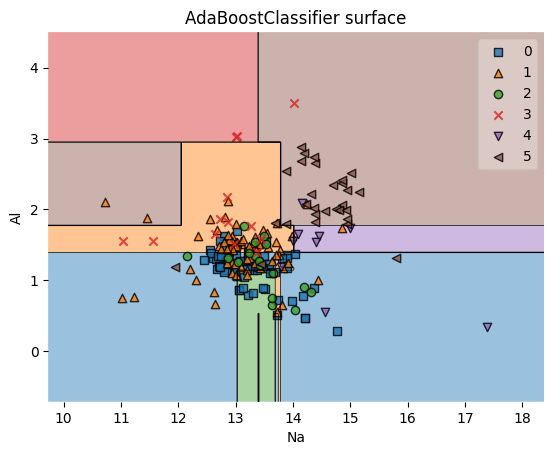

In [27]:
adaboost_clf = AdaBoost(random_state=0)
adaboost_clf.fit(X1_train, y1_train)
adaboost_clf_pred_res = adaboost_clf.predict(X1_test)
adaboost_clf_accuracy = accuracy_score(adaboost_clf_pred_res, y1_test)
print(f'adaboost_clf_accuracy: {adaboost_clf_accuracy}')
print(adaboost_clf_pred_res, '', sep='\n')

sk_adaboost_clf = AdaBoostClassifier(random_state=0, algorithm='SAMME')
sk_adaboost_clf.fit(X1_train, y1_train)
sk_adaboost_clf_pred_res = sk_adaboost_clf.predict(X1_test)
sk_adaboost_clf_accuracy = accuracy_score(sk_adaboost_clf_pred_res, y1_test)
print(f'sk_adaboost_clf_accuracy: {sk_adaboost_clf_accuracy}')
print(sk_adaboost_clf_pred_res)

feature_indexes = [1, 3]
title1 = 'AdaBoostClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_adaboost_clf, feature_indexes, title1)

**Regression**

In [28]:
adaboost_reg = AdaBoost(regression=True, random_state=0)
adaboost_reg.fit(X2_train, y2_train)
adaboost_reg_pred_res = adaboost_reg.predict(X2_test)
mape = mean_absolute_percentage_error(adaboost_reg_pred_res, y2_test)
print(f'adaboost_mape {mape}')
print(adaboost_reg_pred_res, '', sep='\n')

sk_adaboost_reg = AdaBoostRegressor(random_state=0, loss='linear')
sk_adaboost_reg.fit(X2_train, y2_train)
sk_adaboost_reg_pred_res = sk_adaboost_reg.predict(X2_test)
sk_mape = mean_absolute_percentage_error(sk_adaboost_reg_pred_res, y2_test)
print(f'sk_adaboost_mape {sk_mape}')
print(sk_adaboost_reg_pred_res)

adaboost_mape 0.31162122370993556
[239.42353344 230.0610339  167.83786364 109.90928178 184.64646203
 239.42353344 101.90476455 212.98494882 140.80423233 234.56903421
 149.26846999 194.19445742 117.43386255 108.94790608 242.1290679
 113.80597432 154.09826483  98.94335581 115.9061429  215.42377993
 174.95712248 153.4188609  156.40651525 101.90476455 212.98494882
 167.10327877 124.65270476 101.84145017 192.87682861 155.83747832
 199.62919177 101.90476455 117.43386255 149.26846999 149.26846999
 154.09826483 153.4188609  154.49247636 101.3830624  209.29518647
 109.90928178 161.72545559 157.26677336 164.34687775 194.42677031
 101.84145017 121.14501461 138.47917841 118.20881026 221.76239616
 142.75885825 106.54153274 115.59244578 156.73838581 228.18233286
 159.23529268 188.06281057 115.59244578 136.36747076 179.90046612
 235.54909423 136.36747076 146.94594595 117.30376558 235.54909423
 156.55259315 109.14947399 222.75       216.80587827 117.30376558
 101.3830624  149.26846999 124.65270476 138

### **Pros and cons of AdaBoost**
Pros:
- high accuracy with proper data preparation;
- working with complex, non-linear data dependencies;
- high generalizing ability.

Cons:
- low learning rate when working with large datasets;
- the tendency to overfitting with a large number of basic models;
- instability when working with unbalanced data, as well as sensitivity to noise and outliers.

### **Other modifications of adaptive boosting**
Since the generalizing ability of AdaBoost can decrease significantly when working with noisy data, other more stable modifications have been developed. Among the most interesting are the following:
- **L2-Boost** is a modification that uses L2-regularization for the loss function for penalties of less important features, which makes it a more suitable option in regression problems;
- **LogitBoost** is an improvement that is used in classification tasks based on the logistic loss function which speeds up learning and in some cases makes the algorithm more stable;
- **BrownBoost** is a more advanced modification based on the use of a limit on learning from data with incorrect predictions, that is, the model tries to penalize more difficult objects for classification.

### **Additional sources**
Papers:
- «Multi-class AdaBoost», Ji Zhu, Hui Zou, Saharon Rosset and Trevor Hastie;
- «Boosting for Regression Transfer», David Pardoe and Peter Stone;
- «L2 Boosting for Economic Applications», Ye Luo and Martin Spindler;
- «Robust LogitBoost and Adaptive Base Class (ABC) LogitBoost», Ping Li;
- «An adaptive version of the boost by majority algorithm», Yoav Freund.

Documentation:
- [AdaBoost description](https://scikit-learn.org/stable/modules/ensemble.html#adaboost);
- [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html);
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).

Video: [one](https://www.youtube.com/watch?v=LsK-xG1cLYA&t=1110s&ab_channel=StatQuestwithJoshStarmer), [two](https://www.youtube.com/watch?v=UHBmv7qCey4&t=1477s), [three](https://www.youtube.com/watch?v=toOAToTaGV4).
